In [4]:
import numpy as np
from skimage import io, color, measure
import matplotlib.pyplot as plt
from scipy import signal
import matplotlib.pyplot as plt
import math
import os 
from skimage.transform.integral import integral_image

In [42]:
# Ex 1 (20p)

In [5]:
def hog(imagine, tip_nucleu, threshhold):

    #PARAMTERS: imagine,tip_nucleu, threshhold
    #RETURN: GV,GH,histograma gradientilor orientati
    h,w = np.shape(imagine)
    
    # calculul gradientilor Gh si GV in functie de fiecare nucleu
    if(tip_nucleu ==1):
        Gh = -imagine[0:h-1,0:w-1] -2*imagine[0:h-1,1:w] +imagine[1:h,0:w-1] + 2*imagine[1:h,1:w]
        Gv = -imagine[0:h-1,0:w-1]  -2*imagine[1:h,0:w-1] +imagine[0:h-1,1:w] + 2*imagine[1:h,1:w] 
     
    # calcul magnitudine si orientare folosind Gh si Gv
    # puteti folosi math.sqrt si math.atan
    # daca folositi math.atan trebuie sa treceti din [-pi/2,i/2] in [0,pi]
    Mg = np.sqrt(Gh**2 + Gv**2)
    O = np.arctan(Gv/(Gh+0.001)) * (180 / math.pi)
    
    #vectorizare magnitudine si gradienti\
    Mg = Mg.flatten()
    O = O.flatten()

    #anularea orientarilor pentru care magnitudinea este mai mica ca pragul ales
    # altfel spus vreau sa raman in vectorul de orientari doar cu pozitile valorilor
    # pentru care magnitudinea este mai mica decat T
    O[Mg < threshhold] = 1800
    O = O[O != 1800]

    #calculez histograma de orientari pt 9 bins cu np.histogram
    histograma = np.histogram(O, bins=4)[0]
    # print(histograma)

    #normez histograma la suma elementelor si adun si un epsilon ca sa
    #evit situatia in care impart la 0 (blocul contine o regiune uniforma)
    histograma = histograma / (np.sum(histograma) + 1e-5)
  
    return Gh, Gv, histograma

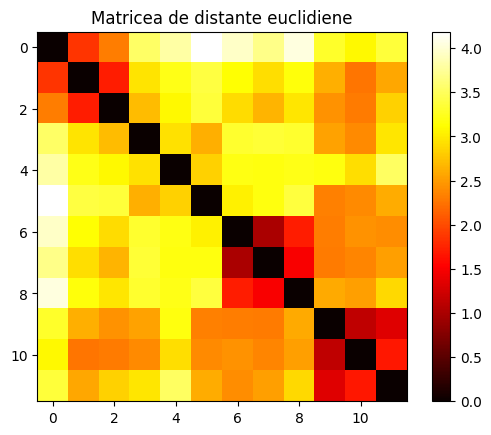

[[ 0  1  2]
 [ 0  1  2]
 [ 1  2 10]
 [ 3  9 10]
 [ 4  5 10]
 [ 5  9 10]
 [ 6  7  8]
 [ 6  7  8]
 [ 6  7  8]
 [ 9 10 11]
 [ 9 10 11]
 [ 9 10 11]]
Nr. fete gasite din 12 =  8
Acuratetea = 66.66666666666666
Rata de clasificare  0.6666666666666666


In [ ]:
# (optional, pentru testare hog)
mask=np.array( [[2,1,1,1,1,1,2],
                [2,4,4,1,4,4,2],
                [1,1,1,0,1,1,1],
                [0,1,1,0,1,1,0],
                [0,1,1,1,1,1,0],
                [0,1,1,2,1,1,0],
                [0,1,1,1,1,1,0]])

def calc_descriptori_hog_poze(poze, path='Lab - 6 HOG/Mari'):

    # poze = os.listdir('Mari')
    descriptori_hog=np.zeros([len(poze),4*49])

    for k, poza in enumerate(poze):
        img = io.imread(os.path.join(path, poza))
        img = color.rgb2gray(img)  # Convert to grayscale if needed
        H,W=np.shape(img)
        step = math.ceil(img.shape[0]/7)
        list_hist = []
        
        for i in range(0, H, step):
            for j in range(0, W, step):
                
                fer = img[i:i+step, j:j+step]
                
                #calculez histograma ferestrei curente si o inmultesc cu masca
                hist_hog = hog(fer,1,0.05)[2]
                hist_norm = hist_hog*mask[i//step,j//step]

                #pun histograma in lista
                list_hist.append(hist_norm)
        
        list_hist = np.array(list_hist)
        descriptori_hog[k,:]=list_hist.flatten()

    return descriptori_hog

def eucdist(vector1, vector2):
    return np.sqrt(np.sum((vector1 - vector2) ** 2))

def calc_distante_descriptori(descriptori):
    nr_imagini = descriptori.shape[0]
    distante = np.zeros((nr_imagini, nr_imagini))

    for i in range(nr_imagini):
        for j in range(i+1, nr_imagini):
            dist = eucdist(descriptori[i], descriptori[j])
            distante[i, j] = dist
            distante[j, i] = dist

    return distante

def calc_nr_fete_similare_dist(distante):

    nr_fete=0

    calc_fete = np.argsort(distante)
    calc_fete_primele3coloane = np.sort(calc_fete[:,:3])
    print(calc_fete_primele3coloane)

    posibile = ['012','345','678','91011']

    for i in range(calc_fete_primele3coloane.shape[0]):
        string = ''
        for j in range(3):
            string+= str(calc_fete_primele3coloane[i,j])
        if string in posibile:
            nr_fete += 1

    print("Nr. fete gasite din 12 = ", nr_fete) 
    print("Acuratetea =", (nr_fete/12)*100)       
    print('Rata de clasificare ',nr_fete/12)

    return nr_fete

poze = os.listdir('Lab - 6 HOG/Mari')

descriptori_hog = calc_descriptori_hog_poze(poze, path='Lab - 6 HOG/Mari')

distante = calc_distante_descriptori(descriptori_hog)

# afisez matricea de distante
plt.imshow(distante, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Matricea de distante euclidiene')
plt.show()

nr_fete_corecte = calc_nr_fete_similare_dist(distante)

In [45]:
# Ex 2 (15p)

In [20]:
def calc_descriptori_hog_poze(poze, path, threshold):

    # poze = os.listdir('Mari')
    descriptori_hog=np.zeros([len(poze),4*4]) # MODIFICAT AICI DUPA MASCA

    for k, poza in enumerate(poze):
        img = io.imread(os.path.join(path, poza))
        img = color.rgb2gray(img)  # Convert to grayscale if needed
        H,W=np.shape(img)
        step = math.ceil(img.shape[0]/3)
        list_hist = []
        
        for i in range(0, H, step):
            for j in range(0, W, step):
                
                i_bloc = i // step
                j_bloc = j // step
                if i_bloc == j_bloc or (i_bloc == 0 and j_bloc == W // step - 1) or (i_bloc == H // step - 1 and j_bloc == 0):
                    continue

                ## sau modificam in masca (0 unde e alb)

                fer = img[i:i+step, j:j+step]
                
                #calculez histograma ferestrei curente si o inmultesc cu masca
                hist_hog = hog(fer,1,threshold)[2]
                hist_norm = hist_hog*mask[i//step,j//step]

                #pun histograma in lista
                list_hist.append(hist_norm)
        
        list_hist = np.array(list_hist)
        descriptori_hog[k,:]=list_hist.flatten()

    return descriptori_hog

In [29]:
poze = os.listdir('Mari_nr_1')
mask = np.array([[1,2,3],
                 [4,5,6],
                 [7,8,9]])
# mask = np.array([[0,2,0],
#                  [4,0,6],
#                  [0,8,0]])
poze = os.listdir('Mari_nr_1')
path='Mari_nr_1'

descriptori_hog = calc_descriptori_hog_poze(poze, path, 0.05)

# afisez matricea de descriptori
print(descriptori_hog)



[[0.46377709 0.71393189 0.45263158 0.36965944 1.7242268  0.65893471
  0.45017182 1.16666666 1.55410903 1.53783563 0.88527258 2.02278274
  1.56118598 3.11518418 2.24402515 1.07960467]
 [0.41478541 0.62664351 0.53535103 0.42322004 1.7891459  0.5435943
  0.45551601 1.21174377 2.06041607 1.12510686 0.6600171  2.15445995
  1.37682165 2.68563497 2.44136016 1.4961832 ]
 [0.50672947 0.53768506 0.40847914 0.54710632 1.29608938 0.63314711
  0.34636871 1.72439478 1.95219347 0.93813273 1.35826771 1.75140607
  0.51935484 3.23870967 3.53548386 0.70645161]
 [0.51059147 0.45061898 0.54855571 0.49023384 1.42942943 0.68348348
  0.54054054 1.34654654 2.2827604  0.90721116 0.92737141 1.88265701
  0.73625498 2.84302788 3.48525896 0.93545817]
 [0.27326151 0.8560235  0.66209598 0.208619   1.29128892 1.0689791
  0.93338589 0.70634608 1.38461538 1.58724202 1.39104797 1.63709461
  1.11147011 4.07969842 2.29186859 0.51696284]
 [0.29888268 0.76536312 0.66014897 0.27560521 1.53355866 0.99661999
  0.73587638 0.7339

In [48]:
# Ex 3

In [30]:
def eucdist(vector1, vector2):
    return np.sqrt(np.sum((vector1 - vector2) ** 2))

def calc_distante_descriptori(descriptori):
    nr_imagini = descriptori.shape[0]
    distante = np.zeros((nr_imagini, nr_imagini))

    for i in range(nr_imagini):
        for j in range(i+1, nr_imagini):
            dist = eucdist(descriptori[i], descriptori[j])
            distante[i, j] = dist
            distante[j, i] = dist

    return distante

In [31]:
def calc_nr_fete_similare_dist(distante):

    nr_fete=0

    calc_fete = np.argsort(distante)
    calc_fete_primele2coloane = np.sort(calc_fete[:,:2])
    print(calc_fete_primele2coloane)

    posibile = ['01','23','45','67']

    for i in range(calc_fete_primele2coloane.shape[0]):
        string = ''
        for j in range(2):
            string+= str(calc_fete_primele2coloane[i,j])
        if string in posibile:
            nr_fete += 1

    print("Nr. fete gasite din 8 = ", nr_fete) 
    print("Acuratetea =", (nr_fete/8)*100)       
    print('Rata de clasificare ',nr_fete/8)

    return nr_fete

In [32]:
def best_prag(thresholds):
    nr_fete_max = 0
    
    for threshold in thresholds:

        poze = os.listdir('Mari_nr_1')
        path='Mari_nr_1'
        descriptori_hog = calc_descriptori_hog_poze(poze, path, threshold)
        distante = calc_distante_descriptori(descriptori_hog)

        nr_fete_corecte = calc_nr_fete_similare_dist(distante)
        if nr_fete_corecte >= nr_fete_max:
            nr_fete_max = nr_fete_corecte
            best_threshold = threshold
    
    return best_threshold, nr_fete_max

In [33]:
best_threshold, nr_fete_max = best_prag([0.05, 0.25, 0.5])
print("Cel mai bun prag este ", best_threshold)
print("Numarul maxim de fete corecte este ", nr_fete_max)

[[0 1]
 [0 1]
 [2 3]
 [2 3]
 [4 5]
 [4 5]
 [6 7]
 [6 7]]
Nr. fete gasite din 8 =  8
Acuratetea = 100.0
Rata de clasificare  1.0
[[0 7]
 [1 3]
 [2 3]
 [1 3]
 [4 5]
 [4 5]
 [1 6]
 [1 7]]
Nr. fete gasite din 8 =  3
Acuratetea = 37.5
Rata de clasificare  0.375
[[0 5]
 [1 7]
 [2 6]
 [0 3]
 [4 5]
 [5 7]
 [0 6]
 [5 7]]
Nr. fete gasite din 8 =  1
Acuratetea = 12.5
Rata de clasificare  0.125
Cel mai bun prag este  0.05
Numarul maxim de fete corecte este  8


In [52]:
# Ex 4

În algoritmul Viola-Jones, ponderile exemplelor:

- Cresc pentru cele clasificate greșit,
- Scad pentru cele clasificate corect.

Acest lucru se întâmplă pentru că algoritmul folosește AdaBoost, care pune accent pe exemplele greșite, astfel încât următorii clasificatori să învețe mai bine de la ele și să reducă greșelile.

In [34]:
# Bonus (optional, pentru testare hog)
# verificare pt Sobel 
a=np.array([[100,85,70],
            [81,80,90],
            [92,83,50]])
Gh, Gv = np.zeros((2,2)), np.zeros((2,2))
Gh,Gv,img_hog=hog(a, 1, 0.85)
print(Gh)
print(Gv)

[[-29  35]
 [ 17 -77]]
[[-17   5]
 [-19 -56]]
